## Simple Linear Regression

In this notebook, we'll build a linear regression model to predict Sales using an appropriate predictor variable.

1. reading and understanding the data
2. Visualising the data
3. Training the model
4. Residual analysis
5. Predicting and evaluating on the test set

## Step 1: Reading and Understanding the Data

Let's start with the following steps:

1. Importing data using the pandas library
2. Understanding the structure of the data

In [2]:
#import libraries

#supress warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#import stas model library
import statsmodels
import statsmodels.api as sm

#-- - - -- - sklearn starts
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

In [3]:
# Read the given CSV file, and view some sample records
advertising = pd.read_csv("advertising.csv")
advertising.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


4th column sales is the target variable, first 3 columns are the predictive variables

each row of dataset represents the market. market has spent 230.1 units for Tv, 37.8 for radio and so on
goal is to build regression model which predicts sales using these 3 variables.

use of this model:many..one is you would know which of these advertising channels is the most effective and which are not working out as expected.


Let's inspect the various aspects of our dataframe

In [4]:
advertising.shape

(200, 4)

In [5]:
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


from above, info to check if any missing values.
it says 200 non-null float 64 . 200 non-null means all 200 rows have no missing values


In [6]:
#good way to see the summary statistics of a dataset is to use describe
#describe takes all the numeric columns and gives youthe summary of all important statistics
advertising.describe()


,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,15.130500
std,85.854236,14.846809,21.778621,5.283892
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,11.000000
50%,149.750000,22.900000,25.750000,16.000000
75%,218.825000,36.525000,45.100000,19.050000
max,296.400000,49.600000,114.000000,27.000000


## Step 2: Visualising the Data

Let's now visualise our data using seaborn. We'll first make a pairplot of all the variables present to visualise which variables are most correlated to `Sales`.

<AxesSubplot:xlabel='TV', ylabel='Sales'>

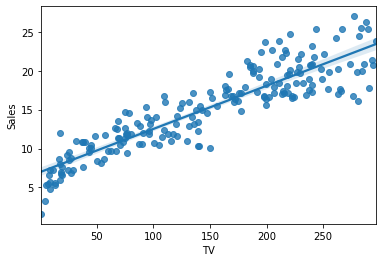

In [7]:
#its better to always visualise the dataset
#in linear regression or any kind of regression, it is better to look at the scatter plot
#bcoz if it shows a positive trend between the target variable and predictive variables, 
#then you will know whether a linear regression or any sort of regression makes sense or not.
#snsreg stands for regression
sns.regplot(x = 'TV', y = 'Sales', data=advertising)
#sns.regplot(x = 'Radio', y = 'Sales', data=advertising)
#sns.regplot(x = 'Newspaper', y = 'Sales', data=advertising)
#visualise all these plots, seems like plot for newspaper is scattered in the y direction, slope is also lesser


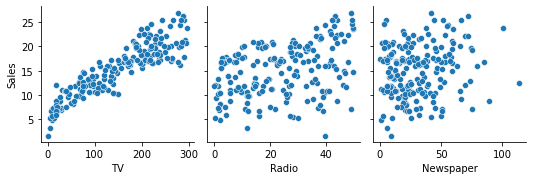

In [8]:
#compare the plots using pair plot
sns.pairplot(data=advertising,
             x_vars=['TV','Radio', 'Newspaper'],
             y_vars='Sales', diag_kind=None)

#or
#sns.pairplot(advertising, x_vars=['TV', 'Newspaper', 'Radio'], y_vars='Sales',size=4, aspect=1, kind='scatter')
#plt.show()

In [9]:
#You can also use heat map to see the correlation between the variables
#corr on a dataframe provides you a nxn matrix where each cell represents corelation between the corresponding variables
advertising.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.901208
Radio,0.054809,1.000000,0.354104,0.349631
Newspaper,0.056648,0.354104,1.000000,0.157960
Sales,0.901208,0.349631,0.157960,1.000000


<AxesSubplot:>

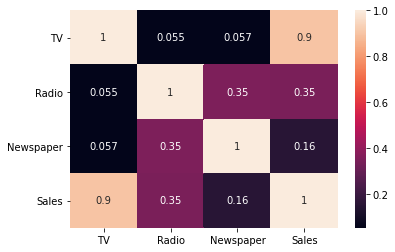

In [10]:
#these no. are not so easy to read on the eye, so visualise this using heatmap this correlation matrix
sns.heatmap(advertising.corr(), annot=True)
#or
#sns.heatmap(advertising.corr(), cmap="YlGnBu", annot = True)
#plt.show()

You read the data and visualised it using 'seaborn'. You also looked at the correlations between the target variable ‘Sales’ and the different predictor variables and saw that ‘TV’ has the strongest correlation with ‘Sales’. Sales and TV are linearly correlated. 

You should always visualise te dataset and get a intuitive understanding of relationship between predictive variable and target variable before you go ahead and build a model.

As is visible from the pairplot and the heatmap, the variable `TV` seems to be most correlated with `Sales`. So let's go ahead and perform simple linear regression using `TV` as our feature variable.

---
## Step 3: Performing Simple Linear Regression

Equation of linear regression<br>
$y = c + m_1x_1 + m_2x_2 + ... + m_nx_n$

-  $y$ is the response
-  $c$ is the intercept
-  $m_1$ is the coefficient for the first feature
-  $m_n$ is the coefficient for the nth feature<br>

In our case:

$y = c + m_1 \times TV$

The $m$ values are called the model **coefficients** or **model parameters**.

---

### Building a Linear Model

In [10]:
#Since 'TV' is very strongly correlated to 'Sales', let's first build a simple linear regression model with ‘TV’ 
#as the predictor variable.

### Generic Steps in model building using `statsmodels`

We first assign the feature variable, `TV`, in this case, to the variable `X` and the response variable, `Sales`, to the variable `y`.

Steps
- create x and y (x is the predictive variable(TV), y is the target variable(sales)
- create train and test set (70-30, 80-20) [70% is train training set, rest 30% is test set on which ll evaluate the model using model evaluation technique]
- Train your model on the training set (i.e. learn the coefficients)
- Evaluate the model(training set, test set)

In [13]:
#create x and y
#capital X, small y: these notations are followed
# X is basically a dataframe, not a column (i.e. tv, radio, ...)
# y is a single column
X = advertising['TV']
y = advertising['Sales']

#### Train-Test Split

You now need to split our variable into training and testing sets. You'll perform this by importing `train_test_split` from the `sklearn.model_selection` library. It is usually a good practice to keep 70% of the data in your train dataset and the rest 30% in your test dataset

In [14]:
#train test-split
#from sklearn.model_selection import train_test_split
#u want 70% of ur dataset sampled randomly and you call it train set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=100)
X_train.shape
X_test.shape

(60,)

In [15]:
# Let's now take a look at the train dataset
X_train.head()

74     213.4
3      151.5
185    205.0
26     142.9
90     134.3
Name: TV, dtype: float64

In [16]:
y_train.head()

74     17.0
3      16.5
185    22.6
26     15.0
90     14.0
Name: Sales, dtype: float64

#### Building a Linear Model

You first need to import the `statsmodel.api` library using which you'll perform the linear regression.

import statsmodels.api as sm

By default, the statsmodels library fits a line on the dataset which passes through the origin. But in order to have an intercept, you need to manually use the add_constant attribute of statsmodels. And once you've added the constant to your X_train dataset, you can go ahead and fit a regression line using the OLS (Ordinary Least Squares) attribute of statsmodels as shown below

In [17]:
#training the model
#u just gave X_train dataframe to stats model ato add constant
# Add a constant to get an intercept
X_train_sm = sm.add_constant(X_train)
X_train_sm.head()

,const,TV
74,1.0,213.4
3,1.0,151.5
185,1.0,205.0
26,1.0,142.9
90,1.0,134.3


In [19]:
#fitting the model = you give the algo to training set which is basically X_train_sm , y_train, you ask algo to learn all the coefficients
#OLS= the way linear regression model is trained is by minimising the sum of the square of the residuals
# sm.OLS(y_train, X_train_sm) creates a linear regression object
# you havnt learnt the coefficient yet, but just created the object of the class OLS
#we ll use this object to create fit

# Fit the resgression line using 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()

In [20]:
# Print the parameters, i.e. the intercept and the slope of the regression line fitted
lr.params

const    6.948683
TV       0.054546
dtype: float64

In [21]:
#the coefficient of the constant i.e. the intercept is 6.94 & coefficient of TV is 0.05
#sales = 6.94 + 0.05 .TV
#if you increase amt of money on tv advertising by 1 unit, sales increases by 0.05 unit
#from tv vs. sales, it is a positive slope as sales increases when advertising on tv inceases
#even if you dont spend on tv, you still get some non zero sales i.e. 6.94
#This is what the model interpretation is like


In [22]:
# Performing a summary operation lists out all the different parameters of the regression line fitted
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     611.2
Date:                Wed, 30 Mar 2022   Prob (F-statistic):           1.52e-52
Time:                        13:03:48   Log-Likelihood:                -321.12
No. Observations:                 140   AIC:                             646.2
Df Residuals:                     138   BIC:                             652.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.9487      0.385     18.068      0.0

####  Looking at some key statistics from the summary

The values we are concerned with are - 
1. The coefficients and significance (p-values)
2. R-squared
3. F statistic and its significance

1. The coefficient for TV is 0.054, with a very low p value
The coefficient is statistically significant. So the association is not purely by chance.

2. R - squared is 0.816
Meaning that 81.6% of the variance in Sales is explained by TV
This is a decent R-squared value.

3. F statistic has a very low p value (practically low)
Meaning that the model fit is statistically significant, and the explained variance isn't purely by chance.

This type of detailed summery only stats model library gives you. sklearn doesnt give you such type of summary of regression model.


coefficients and significance or the p-value of this coefficients. 
p-value is 0 for both the coeficients that means that the coefficients are significant

The p-values of the coefficients (in this case just one coefficient for TV) tell you whether the coefficient is significant or not. In this case, the coefficient of TV came out to be 0.0545 with a standard error of about 0.002. Thus, you got a t-value of 24.722 which lead to a practically zero p-value. Hence, you can say that your coefficient is indeed significant. 

In [18]:
#interpretation from summary of results:
#1. coef and p-value
#2. R-squared is 81.6%, very high => good sign
#3. Prob (F-statistic) is low => the fit is not by chance

In [23]:
###y value for straight line i.e. y = mx + c
y_train_pred = lr.predict(X_train_sm)
y_train_pred

74     18.588747
3      15.212365
185    18.130563
26     14.743271
90     14.274178
         ...    
87     12.986898
103    17.197830
67     14.546907
24     10.346884
8       7.417777
Length: 140, dtype: float64

The fit is significant. Let's visualize how well the model fit the data.
From the parameters that we get, our linear regression equation becomes:
𝑆𝑎𝑙𝑒𝑠=6.948+0.054×𝑇𝑉

S
a
l
e
s
=
6.948
+
0.054
×
T
V
 

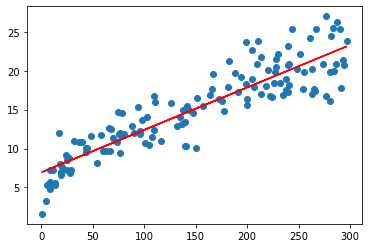

In [24]:
# Plot the prediction of the model 
#make the scatter plot between X and y training set
plt.scatter(X_train, y_train)
#plot what the model is predicting between xtrain and y
#for given x_train what is the y value that the model predicts
#plt.plot(X_train, 6.948 + .054 * X_train, 'r')
plt.plot(X_train, y_train_pred, 'r')
plt.show()

You have visualised the predicted regression line on the scatter plot of the training data which is one of the things you should do as a part of model evaluation.

## Step 4: Residual analysis 
To validate assumptions of the model, and hence the reliability for inference

what is residual analysis?<br>
we are looking for the error terms<br>
#error = f(y_train, y_train_pred)<br>
fundamental assumption in regression, these error terms are normally distributed

#### Distribution of the error terms
We need to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [25]:
#residual
res = y_train - y_train_pred
res

74    -1.588747
3      1.287635
185    4.469437
26     0.256729
90    -0.274178
         ...   
87     3.013102
103    2.502170
67    -1.146907
24    -0.646884
8     -2.617777
Length: 140, dtype: float64

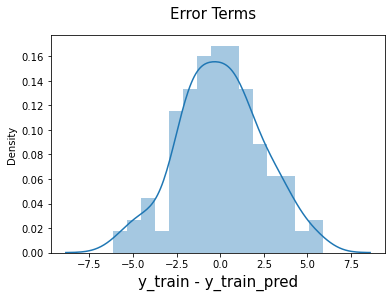

In [26]:
#plot the residuals
#we are plotting histogram to check
#If the error terms are normally distributed
#If the error terms are centred around zero

fig = plt.figure()
sns.distplot(res, bins = 15)
fig.suptitle('Error Terms', fontsize = 15)                  # Plot heading 
plt.xlabel('y_train - y_train_pred', fontsize = 15)         # X-label
plt.show()

First: The errors are normally distributed <br>
from above, the center of normal distribution is around 0.0 and the shape also looks like a good normal distribution.
So, the residuals are following a normal distribution with mean 0. so the assumption of linear regression is respected.

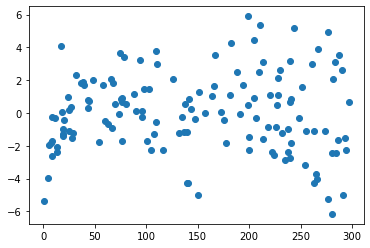

In [23]:
#second: look for patterns in residuals (we should not be able to identify any solid patterns
plt.scatter(X_train, res)
plt.show()
#we have plotted the residuals for all the data points

the residuals are normally distributed and you cannot identify any sort of the patterns
at the right, the variance across the y-axis is quite high

The residuals are normally distributed, and there are no visible patterns in the error terms (except for the fact that the variance seems to be increasing a little for the higher values). So, the regression line is a pretty good fit to the data

## Step 5: Predictions on the Test Set

Now that you have fitted a regression line on your train dataset, it's time to make some predictions on the test data. For this, you first need to add a constant to the `X_test` data like you did for `X_train` and then you can simply go on and predict the y values corresponding to `X_test` using the `predict` attribute of the fitted regression line.

In [24]:
#make predictions on the test set(y_test_pred)
#evaluate the model, r-squared , on the test


In [29]:
#add a constant or intercept to the test set as well
X_test_sm = sm.add_constant(X_test)

#pred on test
y_pred = lr.predict(X_test_sm)

In [30]:
y_pred.head()

126     7.374140
104    19.941482
99     14.323269
92     18.823294
111    20.132392
dtype: float64

###### Checking the R-squared on the test set

In [31]:
#evaluate the model, r-squared , on the test
###import skleran.metrics
r2 = r2_score(y_test, y_pred)
r2

0.7921031601245658

In [32]:
###just tocheck
#r2 on the train set
r2 = r2_score(y_true=y_train, y_pred=y_train_pred)
r2
#anything within 5% is good (definitely 79% is within the 5%) sort of metrics indicate stability
####stability in the sense what the model has learnt on the training set it is generalised that in unseened test as well

0.8157933136480389

In [28]:
#mean squared error
mean_squared_error(y_true=y_test, y_pred=y_test_pred)

4.077556371826956

##### Looking at the RMSE

In [33]:
#Returns the mean squared error; we'll take a square root
np.sqrt(mean_squared_error(y_test, y_pred))

2.019296008966233

r2 is easy to understand as it lies bet -1 and 1. mean squared error is hard to visualise. if you want to compare 2 models using mean_squared error you can use this

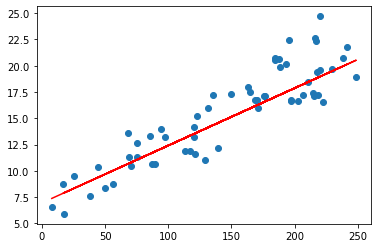

In [29]:
#we computed that the model is able to generalise well on the test set
# lets see prediction on the test set
plt.scatter(X_test, y_test)
plt.plot(X_test, y_test_pred, 'r')
plt.show()

### LINEAR REGRESSION USING SKLEARN

### Linear Regression using `linear_model` in `sklearn`

Apart from `statsmodels`, there is another package namely `sklearn` that can be used to perform linear regression. We will use the `linear_model` library from `sklearn` to build the model. Since, we hae already performed a train-test split, we don't need to do it again.

There's one small step that we need to add, though. When there's only a single feature, we need to add an additional column in order for the linear regression fit to be performed successfully.

In [34]:
#we will start from step 2, splitting train and test set
X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(X, y, train_size=0.70, random_state=100)


#steps in sklearn model building 
1. create an object of linear regression
2. fit the model 
3. see the params, make predictions(train, test)
4. evaluate (r2..etc)

In [35]:
X_train_lm.shape

(140,)

In [36]:
#fit the model
#X_train.shape
#reshape xtrain to a matrix as fit method expects a 2d array
#reshape to (140, 1)
X_train_lm = X_train.values.reshape(-1, 1)
#X_train_lm.shape
X_test_lm = X_test.values.reshape(-1, 1)

In [37]:
print(X_train_lm.shape)
print(y_train_lm.shape)
print(X_test_lm.shape)
print(y_test_lm.shape)

(140, 1)
(140,)
(60, 1)
(60,)


In [38]:
#create an object of linear regression
#use LinearRegression class to create object
#lm is linear model
lm = LinearRegression()

In [39]:
#fit the model
#we dont need to reshape y_train, as sklearn excepcts to single series
lm.fit(X_train_lm, y_train)

LinearRegression()

In [40]:
help(lm)

Help on LinearRegression in module sklearn.linear_model._base object:

class LinearRegression(sklearn.base.MultiOutputMixin, sklearn.base.RegressorMixin, LinearModel)
 |  LinearRegression(*, fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
 |  
 |  Ordinary least squares Linear Regression.
 |  
 |  LinearRegression fits a linear model with coefficients w = (w1, ..., wp)
 |  to minimize the residual sum of squares between the observed targets in
 |  the dataset, and the targets predicted by the linear approximation.
 |  
 |  Parameters
 |  ----------
 |  fit_intercept : bool, default=True
 |      Whether to calculate the intercept for this model. If set
 |      to False, no intercept will be used in calculations
 |      (i.e. data is expected to be centered).
 |  
 |  normalize : bool, default=False
 |      This parameter is ignored when ``fit_intercept`` is set to False.
 |      If True, the regressors X will be normalized before regression by
 |      subtracting the mean

In [42]:
#make predictions
y_train_pred = lm.predict(X_train_lm)
y_test_pred = lm.predict(X_test_lm)

In [43]:
#4.evaluate the model
print(r2_score(y_true=y_train, y_pred=y_train_pred))
print(r2_score(y_true=y_test, y_pred=y_test_pred))

0.8157933136480389
0.7921031601245662


In [44]:
#see the params, make predictions(train, test)
print(lm.coef_)
print(lm.intercept_)

[0.05454575]
6.948683200001357


The equationwe get is the same as what we got before!

$ Sales = 6.948 + 0.054* TV $

Sklearn linear model is useful as it is compatible with a lot of sklearn utilites (cross validation, grid search etc.)